```fortran
!-------
 subroutine readpdg(hadron,nhadron,source)
 integer, intent(in)                            :: nhadron
 character(len=8), intent(in)                   :: source
 type(particle), dimension(nhadron),intent(out) :: hadron
 integer                                        :: i,j

 if ("resoweak" == source)then
 do i =1,nhadron !107
 read(11,*) hadron(i)%pid,hadron(i)%name,hadron(i)%mass,hadron(i)%b , &
           hadron(i)%degen, hadron(i)%baryon,hadron(i)%strange, &
           hadron(i)%d1,hadron(i)%d2,hadron(i)%d3,hadron(i)%charge, &
          hadron(i)%skip,hadron(i)%npi, hadron(i)%nK , hadron(i)%neta
! write(*,*)hadron(i)%pid, hadron(i)%name, hadron(i)%b, hadron(i)%neta
!    write(*,*) hadron(i)%skip

 do j=1,hadron(i)%skip
   read(11,*) hadron(i)%a1,hadron(i)%a2,hadron(i)%a3, &
               hadron(i)%a4,hadron(i)%a5,hadron(i)%a6, &
               hadron(i)%a7,hadron(i)%a8
!    write(*,*) hadron(i)%a1,hadron(i)%a3
  enddo
 enddo
endif  ! endif for resoweak.dat

 if ("pdg05" == source)then
! mc-number  name  mass  width  deg  nb  ns  nc  nbot  isospin  charge  #decays
! here d1->nc, d2-> nbot, d3-> isospin
```

In [21]:
import numpy as np
import pandas as pd

import numpy as np
from matplotlib import pyplot as plt
import scipy as sp

resolution = 100

In [22]:
filename = "resoweak.dat"
particles = []
def process(a):
    for i, a_ in enumerate(a):
        if i == 0: a[i] = int(a_)
        elif i > 1: a[i] = float(a_)
    return a

# pid, name, mass, width, degen, baryon, strange, nc, nbot, isospin, charge, skip, npi, nK, neta
with open(filename) as file:
    lines = file.readlines()
    for line in lines:
        a = line.split()
        if len(a) == 15:
            a = process(a)
            particles.append(a)

particles = pd.DataFrame(
    particles,
    columns=[
        "pid", "name", "mass", "width", "degen", "baryon",
        "strange", "nc", "nbot", "isospin", "charge", "skip",
        "npi", "nK", "neta"
    ],
)

In [23]:
particles

,pid,name,mass,width,degen,baryon,strange,nc,nbot,isospin,charge,skip,npi,nK,neta
0,22,Gamma(),0.00000,0.00,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.00,0.00,0.00
1,211,Pion(+),0.13957,0.00,1.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,1.00,0.00,0.00
2,111,Pion(0),0.13498,0.00,1.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,1.00,0.00,0.00
3,-211,Pion(-),0.13957,0.00,1.0,0.0,0.0,0.0,1.0,3.0,-1.0,1.0,1.00,0.00,0.00
4,321,Kaon(+),0.49368,0.00,1.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,1112,Del_1620(-),1.62000,0.15,2.0,1.0,0.0,0.0,0.0,4.0,-1.0,4.0,1.75,0.00,0.00
103,60223,omega_1650(),1.64900,0.22,3.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,3.00,0.00,0.00
104,32212,p_1650(),1.65000,0.15,2.0,1.0,0.0,0.0,0.0,2.0,1.0,9.0,1.05,0.05,0.05
105,32112,n_1650(),1.65000,0.15,2.0,1.0,0.0,0.0,0.0,2.0,0.0,9.0,1.05,0.05,0.05


$$
\epsilon(T) = \sum_{i=1}^{\text{all the particles}} \frac{Z_ie^{\mu/T}m_i}{2\pi^2} \left[ 3T^2K_2\left(\frac{m_i}{T}\right) + TK_1\left(\frac{m_i}{T}\right) \right]
$$

$$
P(T) = \sum_{i=1}^{\text{all the particles}} \frac{Z_ie^{\mu/T}m_i}{2\pi^2} \left[ T^2 K_2\left(\frac{m_i}{T}\right) \right]
$$

$$
s(T) = \sum_{i=1}^{\text{all the particles}} \frac{Z_ie^{\mu/T}m_i}{2\pi^2} \left[ K_3\left( \frac{m_i}{T}\right) \right]
$$

In [24]:
class EoS:
    def __init__(self, particles):
        # remove all the particles with mass 0
        self.particles = particles[particles["mass"] != 0]
        self.Z = self.particles["degen"].to_numpy().reshape(-1, 1)
        self.m = self.particles["mass"].to_numpy().reshape(-1, 1)

    # def energy_density1(self, T:np.array, mu:float):
    #     T = T.T  # transpose the temperature array
    #     coeff = (self.Z @ np.exp(mu/T)) * (self.m @ T) / (2*np.pi**2)
    #     x = self.m @ (1/T)
    #     term = 3*T**2 * sp.special.kn(2, x) + T * sp.special.kn(1, x)
    #     return np.sum(coeff * term, axis = 0)

    def energy_density(self, T:np.array, mu:float):
        ret = []
        for temp in T:
            coeff = self.Z * np.exp(mu/temp) * self.m / (2*np.pi**2)
            term = 3*temp**2 * sp.special.kn(2, self.m/temp) + temp * sp.special.kn(1, self.m/temp)
            ret.append(np.sum(coeff * term))
        return np.array(ret)

    def pressure(self, T:np.array, mu:float):
        ret = []
        for temp in T:
            coeff = self.Z * np.exp(mu/temp) * self.m**2 / (2*np.pi**2)
            term = 3*temp**2 * sp.special.kn(2, self.m/temp)
            ret.append(np.sum(coeff * term))
        return np.array(ret)

    def entropy_density(self, T:np.array, mu:float):
        ret = []
        for temp in T:
            coeff = self.Z * np.exp(mu/temp) * self.m**2 / (2*np.pi**2)
            term = sp.special.kn(2, self.m/temp)
            ret.append(np.sum(coeff * term))
        return np.array(ret)

ps = EoS(particles)

In [25]:
T = np.linspace(0.1, 0.7, resolution).reshape(-1, 1)
mu = 0

In [26]:
eps = ps.energy_density(T, mu)
# plt.plot(T, eps)

In [27]:
pr = ps.pressure(T, mu)
# plt.plot(T, pr)

In [28]:
sd = ps.entropy_density(T, mu)
# plt.plot(T, sd)

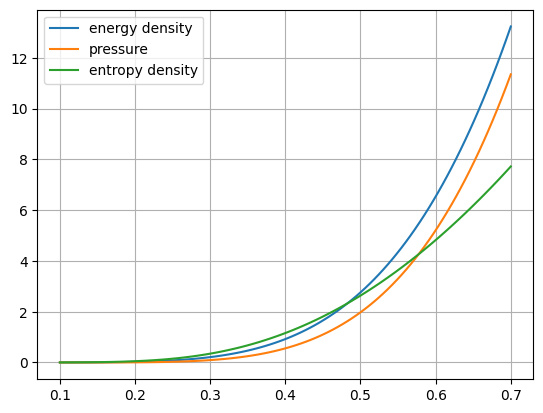

In [29]:
plt.plot(T, eps, label="energy density")
plt.plot(T, pr, label="pressure")
plt.plot(T, sd, label="entropy density")
plt.grid()
plt.legend()